In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
from torchvision import models
from torch.optim.lr_scheduler import StepLR
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data_dir = "data/raw-img"

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float16),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
full_dataset = ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)

In [6]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

In [7]:
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size], 
    generator=torch.Generator().manual_seed(42)
)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

In [9]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [10]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

In [11]:
def unfreeze_layers(model, epoch):
    if epoch == 1:
        for param in model.layer4.parameters():
            param.requires_grad = True
        print("Unfreeze layer4")
    elif epoch == 2:
        for param in model.layer3.parameters():
            param.requires_grad = True
        print("Unfreeze layer3")
    elif epoch == 3:
        for param in model.layer2.parameters():
            param.requires_grad = True
        print("Unfreeze layer2")
    elif epoch == 4:
        for param in model.layer1.parameters():
            param.requires_grad = True
        print("Unfreeze layer1")


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # using scheduler here, because with fixed lr I received bad results
scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None

In [13]:
train_losses = []
test_losses = []
f1_scores = []
best_f1 = 0.0

In [14]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            if scaler:
                with torch.amp.autocast(device_type='cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, f1, all_preds, all_labels

In [15]:
num_epochs = 30
for epoch in range(num_epochs):
    unfreeze_layers(model, epoch)

    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    test_loss, test_f1, _, _ = evaluate_model(model, train_loader)
    test_losses.append(test_loss)
    f1_scores.append(test_f1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {avg_train_loss:.4f}, Test loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")
    
    
    if test_f1 > best_f1:
        best_f1 = test_f1

    scheduler.step()
torch.save(model.state_dict(), "./model/model_first.pth")

Epoch 1/30, Train loss: 0.3118, Test loss: 0.1025, Test F1: 0.9784
Unfreeze layer4
Epoch 2/30, Train loss: 0.1073, Test loss: 0.0690, Test F1: 0.9848
Unfreeze layer3
Epoch 3/30, Train loss: 0.0848, Test loss: 0.0516, Test F1: 0.9884
Unfreeze layer2
Epoch 4/30, Train loss: 0.0718, Test loss: 0.0405, Test F1: 0.9908
Unfreeze layer1
Epoch 5/30, Train loss: 0.0597, Test loss: 0.0337, Test F1: 0.9930
Epoch 6/30, Train loss: 0.0515, Test loss: 0.0311, Test F1: 0.9939
Epoch 7/30, Train loss: 0.0475, Test loss: 0.0287, Test F1: 0.9942
Epoch 8/30, Train loss: 0.0445, Test loss: 0.0257, Test F1: 0.9947
Epoch 9/30, Train loss: 0.0400, Test loss: 0.0233, Test F1: 0.9958
Epoch 10/30, Train loss: 0.0408, Test loss: 0.0218, Test F1: 0.9957
Epoch 11/30, Train loss: 0.0347, Test loss: 0.0210, Test F1: 0.9961
Epoch 12/30, Train loss: 0.0342, Test loss: 0.0203, Test F1: 0.9961
Epoch 13/30, Train loss: 0.0339, Test loss: 0.0196, Test F1: 0.9967
Epoch 14/30, Train loss: 0.0317, Test loss: 0.0190, Test F1: 

In [30]:
model.load_state_dict(torch.load("./model/model_first.pth"))

<All keys matched successfully>

In [31]:
_, val_f1, all_preds, all_labels = evaluate_model(model, val_loader)
print(f"Val F1-score: {val_f1:.4f}")


Val F1-score: 0.9776


In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),  
    transforms.ColorJitter(brightness=0.3),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float16),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [17]:
full_dataset = ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)

In [18]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

In [19]:
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator = torch.Generator().manual_seed(42)
)

In [20]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 8, pin_memory = True)

test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, num_workers = 8, pin_memory = True)

In [21]:
for epoch in range(num_epochs):


    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    test_loss, test_f1, _, _ = evaluate_model(model, train_loader)
    test_losses.append(test_loss)
    f1_scores.append(test_f1)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {avg_train_loss:.4f}, Test loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")
    
    
    if test_f1 > best_f1:
        best_f1 = test_f1

    scheduler.step()
torch.save(model.state_dict(), "./model/model_second.pth")

Epoch 1/30, Train loss: 0.0921, Test loss: 0.0663, Test F1: 0.9791
Epoch 2/30, Train loss: 0.0872, Test loss: 0.0687, Test F1: 0.9764
Epoch 3/30, Train loss: 0.0866, Test loss: 0.0671, Test F1: 0.9788
Epoch 4/30, Train loss: 0.0867, Test loss: 0.0656, Test F1: 0.9800
Epoch 5/30, Train loss: 0.0889, Test loss: 0.0638, Test F1: 0.9799
Epoch 6/30, Train loss: 0.0863, Test loss: 0.0659, Test F1: 0.9789
Epoch 7/30, Train loss: 0.0853, Test loss: 0.0648, Test F1: 0.9799
Epoch 8/30, Train loss: 0.0823, Test loss: 0.0661, Test F1: 0.9792
Epoch 9/30, Train loss: 0.0849, Test loss: 0.0693, Test F1: 0.9784
Epoch 10/30, Train loss: 0.0849, Test loss: 0.0647, Test F1: 0.9784
Epoch 11/30, Train loss: 0.0853, Test loss: 0.0625, Test F1: 0.9816
Epoch 12/30, Train loss: 0.0858, Test loss: 0.0616, Test F1: 0.9808
Epoch 13/30, Train loss: 0.0820, Test loss: 0.0641, Test F1: 0.9796
Epoch 14/30, Train loss: 0.0857, Test loss: 0.0623, Test F1: 0.9800
Epoch 15/30, Train loss: 0.0846, Test loss: 0.0653, Test 

In [22]:
model.load_state_dict(torch.load("./model/model_second.pth"))

<All keys matched successfully>

In [23]:
_, val_f1, all_preds, all_labels = evaluate_model(model, val_loader)
print(f"Val F1-score: {val_f1:.4f}")


Val F1-score: 0.9725


First model is better

In [34]:
model.load_state_dict(torch.load("./model/model_first.pth"))

<All keys matched successfully>

In [35]:
_, val_f1, all_preds, all_labels = evaluate_model(model, val_loader)
print(f"Val F1-score: {val_f1:.4f}")

Val F1-score: 0.9801


In [36]:
cm = confusion_matrix(all_labels, all_preds)

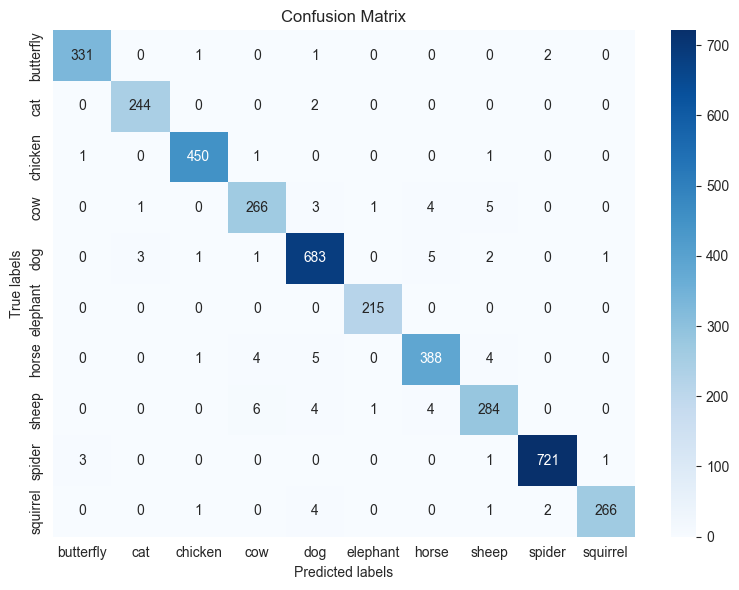

In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else 'auto',
                yticklabels=class_names if class_names else 'auto')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

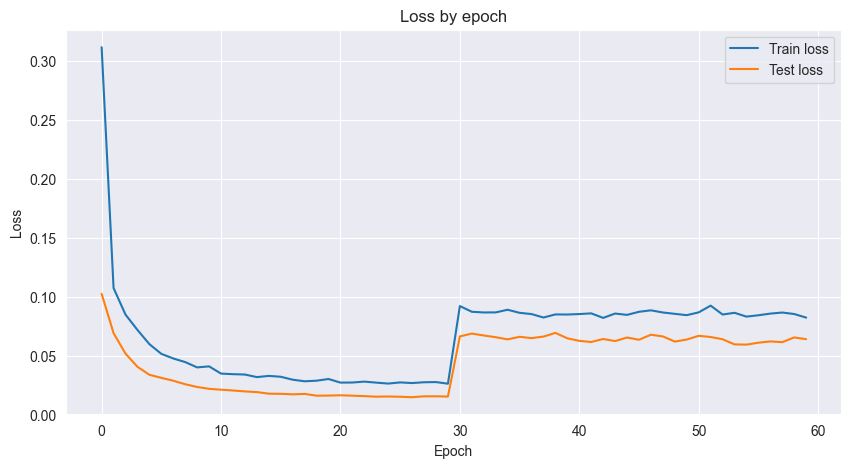

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by epoch')
plt.legend()
plt.show()

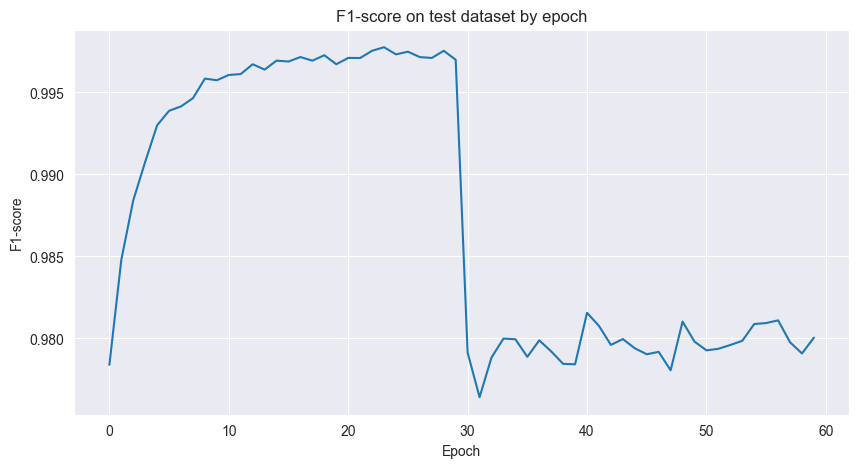

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(f1_scores, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.title('F1-score on test dataset by epoch')
plt.show()

In [40]:
def visualize_misclassified_samples(model, test_loader, class_names, num_samples=10):
    model.half()
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            incorrect_mask = (predicted != labels)
            if incorrect_mask.any():
                incorrect_images = images[incorrect_mask]
                incorrect_labels = labels[incorrect_mask]
                incorrect_preds = predicted[incorrect_mask]
                
                for img, label, pred in zip(incorrect_images, incorrect_labels, incorrect_preds):
                    if len(misclassified_images) < num_samples:
                        misclassified_images.append(img.cpu())
                        misclassified_labels.append(label.item())
                        misclassified_preds.append(pred.item())
                    else:
                        break
            
            if len(misclassified_images) >= num_samples:
                break
    
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, (img, true_label, pred_label) in enumerate(zip(misclassified_images, misclassified_labels, misclassified_preds)):
        if i < len(axes):
            img = img.float()
            img = img * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
            img = img.clamp(0, 1)
            
            axes[i].imshow(img.permute(1, 2, 0))
            axes[i].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

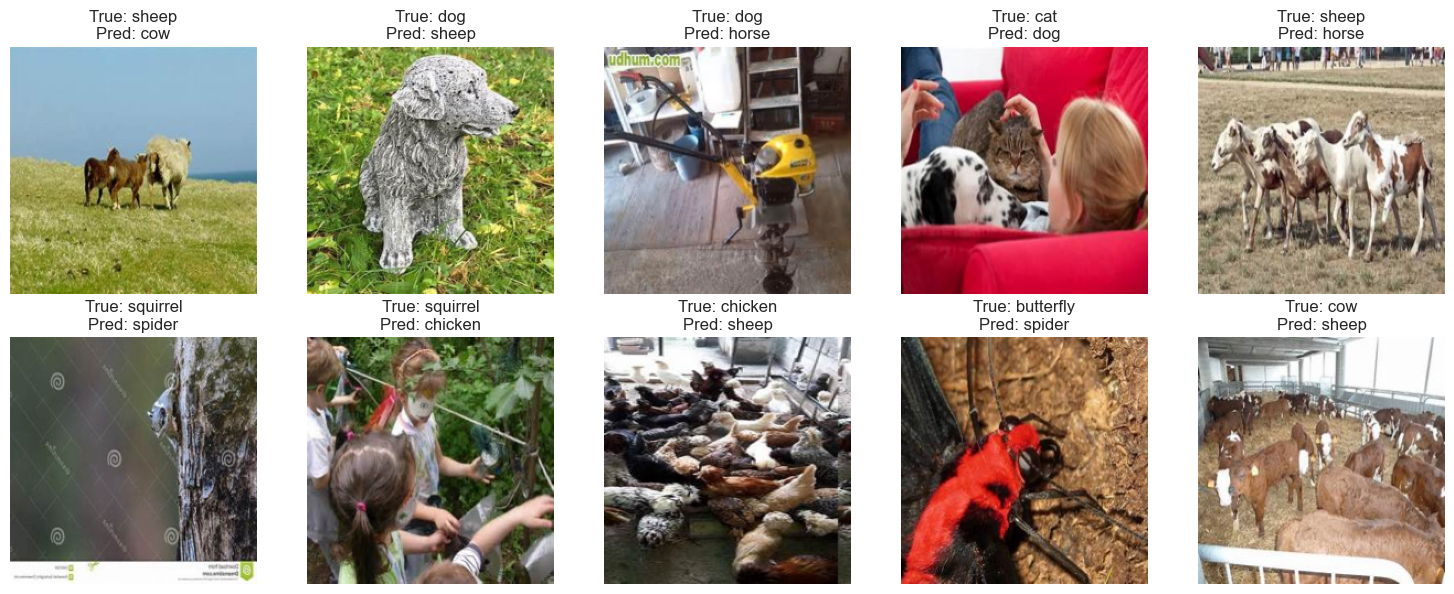

In [41]:
visualize_misclassified_samples(model, val_loader, class_names)

1. The brown sheep next to the white one look like a cow.
2. The dog in the foam looks like a sheep.
3. For some reason, the image of the machine was attributed to the dog, so it would be surprising if it recognised it correctly.
4. The image contains both a cat and a dog
5. Skinny sheep resemble horses.
6. The squirrel is photographed similarly to the spiders on the trees.
7. The squirrel is not clearly visible
8. A lot of chickens, so it may look like a sheep from this angle.
9. Too close an angle, the insect looks like a spider.
10. Lots of brown and white cows, so it may look like skinny sheep

